In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Telco-Customer-Churn.csv')

# Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [5]:
df.isna().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [6]:
df.shape

(7043, 21)

In [7]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


At the first looking at data, we do not have null data to evaluate. We have categorical and numerical columns. Let's look at them

In [8]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    :param dataframe: This is our data we are working on.
    :param cat_th: This is the threshold for checking numeric columns if they are actually numeric or categoric
    :param car_th: If a categorical variable has more than 20 observations, data mining is difficult.
     Thus it is said to be cardinal variable.
    :return: The function returns categorical, numerical and cardinal columns
    """
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'O']

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != 'O']

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == 'O']

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in dataframe.columns if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in dataframe.columns if col not in num_but_cat]

    print(f'Observations: {dataframe.shape[0]}')
    print(f'Variables: {dataframe.shape[1]}')
    print(f'Categorical columns: {len(cat_cols)}')
    print(f'Numeric columns: {len(num_cols)}')
    print(f'Num_but_cat columns: {len(num_but_cat)}')
    print(f'Cat_but_car columns: {len(cat_but_car)}')

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 21
Categorical columns: 19
Numeric columns: 20
Num_but_cat columns: 1
Cat_but_car columns: 2


# Outliers

Values that are quite different than the general trend of data is said to be outlier. Outliers are big problem especially in linear models such as linear regression and logistic regression. However tree models such as Random Forest Regressor/Classifier, XGB Regressor/Classifier can handle outliers.

Outliers can be evaluated with two main methods. Removing or replacing.

Removing data can be dangerous especially in small datasets so if you do not work on a big data, removing outlier is not suggested.

If data is categorical, we can replace outlier with mode value. If data is numerical, mean or median can be used in order to replace outliers.

In [9]:
def outlier_detector(dataframe, third=0.9, first=0.1):
    outliers_info = {}

    for col in dataframe.columns:
        if dataframe[col].dtype in ['float64', 'int64']:
            q3 = dataframe[col].quantile(third)
            q1 = dataframe[col].quantile(first)
            iqr = q3 - q1
            low = q1 - 1.5 * iqr
            up = q3 + 1.5 * iqr

            outliers = dataframe[(dataframe[col] > up) | (dataframe[col] < low)]
            outliers_count = len(outliers)

            if outliers_count > 0:
                outliers_info[col] = outliers_count

    return outliers_info

outliers_in_columns = outlier_detector(df)
print(outliers_in_columns)

{}


According to outlier detector function, we do not have outlier to evaluate.

# Missing Values

Missing values can be occured by user such as in forms. As outliers, they can be filled or removed.

Filling missing values method is same with outliers.

In [10]:
def missing_values_table(dataframe, na_name=False):
    na_cols = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_cols].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_cols].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end='\n')

    if na_name:
        return na_cols


missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


According to missing values table function, we do not have missing value to fill

# Feature Extraction

New features can be extracted from the actual data in order to determine other useful relationships for a better model score.

For this processing, data must be examined carefully.

In [11]:
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


Customer ID columns is unique for all customers. It means it has no information about the customer. We can remove this column.

In [12]:
df = df.drop('customerID', axis = 1)

In [13]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [14]:
pd.DataFrame(df, columns = ['SeniorCitizen', 'PaymentMethod'])

,SeniorCitizen,PaymentMethod
0,0,Electronic check
1,0,Mailed check
2,0,Mailed check
3,0,Bank transfer (automatic)
4,0,Electronic check
...,...,...
7038,0,Mailed check
7039,0,Credit card (automatic)
7040,0,Electronic check
7041,1,Mailed check


In [15]:
df['InternetService'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [16]:
df[(df['InternetService'] == 'No')].sort_values(by = 'tenure', ascending = False)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7037,Female,0,No,No,72,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),21.15,1419.4,No
6423,Female,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.25,1784.5,No
1869,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
3382,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),25.55,1867.7,No
3466,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),25.10,1790.8,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No


# Data Visulation

- Gender

In [17]:
df['gender'].unique()

array(['Female', 'Male'], dtype=object)

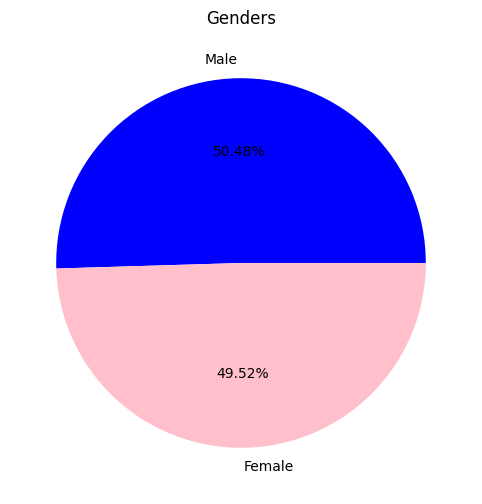

In [18]:
male = df['gender'].value_counts()['Male']
female = df['gender'].value_counts()['Female']

labels = ['Male', 'Female']
values = [male, female]
colors = ['blue', 'pink']

plt.figure(figsize = (9, 6))
plt.title('Genders')
plt.pie(values, labels = labels, colors = colors, autopct = '%1.2f%%')
plt.show()

It seems there is a gender equality here

- Internet Service

<Axes: xlabel='InternetService', ylabel='Count'>

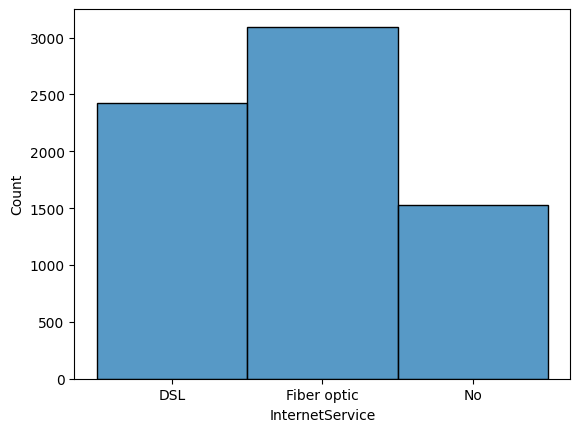

In [19]:
sns.histplot(df['InternetService'])

- Tenure

<Axes: xlabel='gender', ylabel='tenure'>

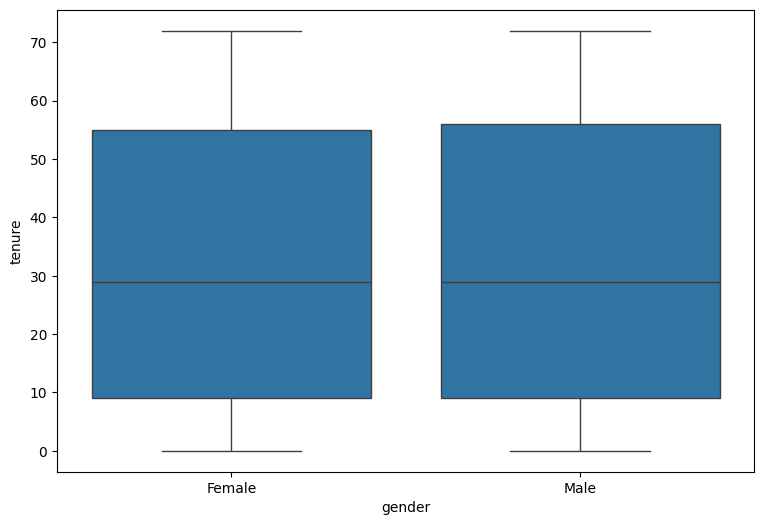

In [20]:
plt.figure(figsize = (9, 6))
sns.boxplot(data = df, x = 'gender', y = 'tenure')

Behaviors of men and women are almost same for staying at that company.

- Payment Method

<Axes: xlabel='PaymentMethod', ylabel='Count'>

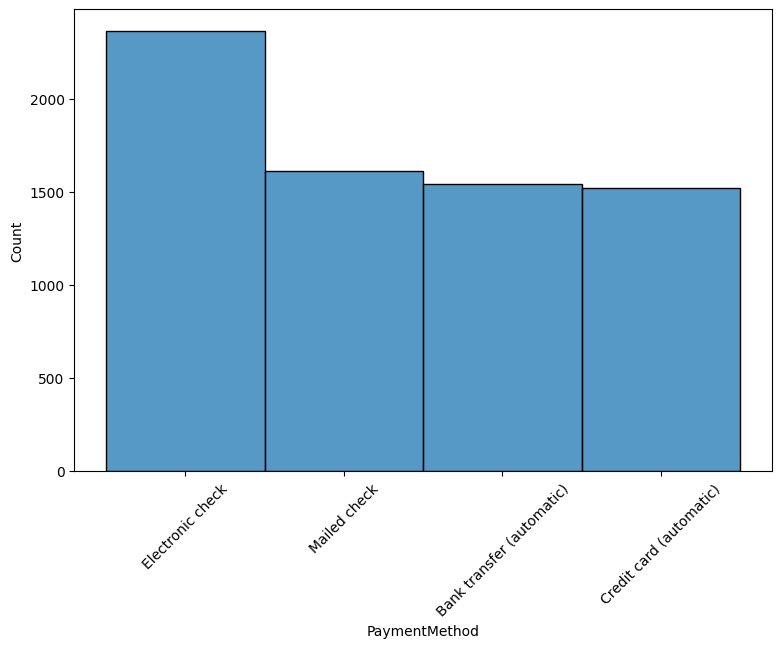

In [21]:
plt.figure(figsize = (9, 6))
plt.xticks(rotation = 45)
sns.histplot(df['PaymentMethod'])

Most of customers prefer electronic check as a payment method. The frequency of preferred is similar for other methods.

In [22]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [23]:
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)

In [24]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

In [25]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

In [26]:
df['TotalCharges'].dtype

dtype('float64')

In [27]:
df['TotalCharges'].isna().sum()

0

In [28]:
df['gender'].dtype

dtype('O')

<Axes: xlabel='gender', ylabel='TotalCharges'>

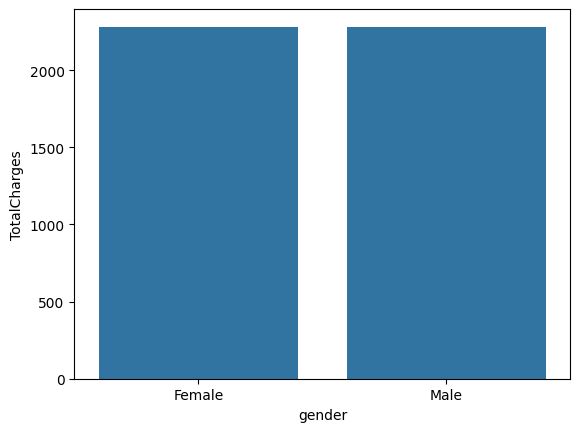

In [29]:
gender_and_total_charges = df.groupby('gender')['TotalCharges'].mean().reset_index()

sns.barplot(x = gender_and_total_charges['gender'], y = gender_and_total_charges['TotalCharges'])

In [30]:
gender_and_total_charges

,gender,TotalCharges
0,Female,2281.921323
1,Male,2281.912616


Total charge is almost same for each gender too

# Correlation Analysis

In [31]:
numeric_columns = df.select_dtypes(include=np.number)
correlation = numeric_columns.corr()

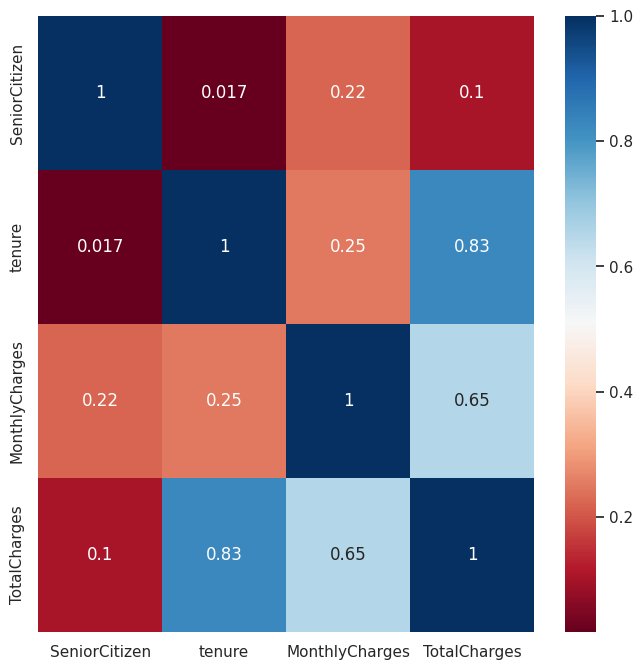

In [32]:
sns.set(rc={'figure.figsize': (8, 8)})
sns.heatmap(correlation, cmap="RdBu", annot=True)
plt.show()

There is a strong relationship between Tenure-Total Charges and Monthly Charges-Total Charges

We can evaluate this situation later

# Encoding

In [33]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def encoding_columns(dataframe):



  ohe_cols = [col for col in dataframe.columns if 10 >= dataframe[col].nunique() > 2]


  useless_cols = []
  for col in dataframe.columns:
      if dataframe[col].nunique() == 2:
          value_counts = dataframe[col].value_counts() / len(dataframe)
          if (value_counts < 0.01).any():
              useless_cols.append(col)

  print(ohe_cols)
  print(useless_cols)
  return ohe_cols, useless_cols


ohe_cols, useless_cols = encoding_columns(df)

['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
[]


They are the columns we must do one hot encoding. We do not have any useless columns to remove.

In [34]:
le_cols = [col for col in cat_cols if col not in ohe_cols and
           col not in useless_cols]

In [35]:
df = pd.get_dummies(df, columns = ohe_cols)

In [36]:
for col in le_cols:
  df[col] = le.fit_transform(df[col])

In [37]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,142,29.85,0,...,True,False,False,True,False,False,False,False,True,False
1,1,0,0,0,34,1,0,498,1889.50,0,...,True,False,False,False,True,False,False,False,False,True
2,1,0,0,0,2,1,1,436,108.15,1,...,True,False,False,True,False,False,False,False,False,True
3,1,0,0,0,45,0,0,266,1840.75,0,...,True,False,False,False,True,False,True,False,False,False
4,0,0,0,0,2,1,1,729,151.65,1,...,True,False,False,True,False,False,False,False,True,False


We converted categorical data to numeric in order to use in machine learning algorithms. But some big numbers may be seen dominant from the machine so we need to scale them for a better score.

# Scaling

In [38]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
will_add = df['Churn']
scaling_df = df.drop('Churn', axis = 1)
original_cols = scaling_df.columns
scaled_df = ss.fit_transform(scaling_df)
df = pd.DataFrame(scaled_df, columns = original_cols)
df['Churn'] = will_add

In [39]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No,...,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,-1.009559,-0.439916,1.034530,-0.654012,-1.277445,-3.054010,0.829798,-1.131766,-0.994242,-0.963330,...,-0.525927,-0.79607,0.904184,-0.514249,-0.562975,-0.529885,-0.525047,1.406418,-0.544807,0
1,0.990532,-0.439916,-0.966622,-0.654012,0.066327,0.327438,-1.205113,-0.387740,-0.173244,1.038066,...,-0.525927,-0.79607,-1.105970,1.944582,-0.562975,-0.529885,-0.525047,-0.711026,1.835513,0
2,0.990532,-0.439916,-0.966622,-0.654012,-1.236724,0.327438,0.829798,-0.517317,-0.959674,1.038066,...,-0.525927,-0.79607,0.904184,-0.514249,-0.562975,-0.529885,-0.525047,-0.711026,1.835513,1
3,0.990532,-0.439916,-0.966622,-0.654012,0.514251,-3.054010,-1.205113,-0.872611,-0.194766,-0.963330,...,-0.525927,-0.79607,-1.105970,1.944582,-0.562975,1.887201,-0.525047,-0.711026,-0.544807,0
4,-1.009559,-0.439916,-0.966622,-0.654012,-1.236724,0.327438,0.829798,0.095041,-0.940470,1.038066,...,-0.525927,-0.79607,0.904184,-0.514249,-0.562975,-0.529885,-0.525047,1.406418,-0.544807,1


Now our data is ready for machine learning

# Model Selection

We are gonna predict if the customer will stay in company or not. Thus it is a classification problem. Let's import required libraries

In [40]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [41]:
y = df['Churn']
x = df.drop('Churn', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 42, train_size = 0.8)

In [42]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.68      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.81      0.82      0.82      1409



In [43]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1036
           1       0.67      0.47      0.55       373

    accuracy                           0.80      1409
   macro avg       0.75      0.69      0.71      1409
weighted avg       0.79      0.80      0.79      1409



In [44]:
xg = XGBClassifier()
xg.fit(X_train, y_train)
xg_pred = xg.predict(X_test)
print(classification_report(y_test, xg_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1036
           1       0.63      0.51      0.57       373

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



In [45]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
gbc_pred = gbc.predict(X_test)
print(classification_report(y_test, gbc_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1036
           1       0.67      0.53      0.59       373

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



In [46]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=5, scoring='f1_weighted')
grid_search.fit(X_train, y_train)


print("Best Hyperparameters:", grid_search.best_params_)


print("Best F1 Score:", grid_search.best_score_)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best F1 Score: 0.7939056976684908
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1036
           1       0.67      0.54      0.60       373

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



In [47]:
gbr = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 3, min_samples_leaf = 4, min_samples_split = 10, n_estimators = 100)
gbr.fit(X_train, y_train)
prediction = gbr.predict(X_test)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1036
           1       0.67      0.54      0.60       373

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409

